# Sentiment Analysis

In [1]:
import os

import pandas as pd

# ====== Preprocessing ==========================
# Read raw data
# Trip advisor
master_dir = os.path.dirname(os.getcwd())
file_tripadvisor = os.path.join(master_dir, "data_cleaned", "TripAdvisor_data_cleaned.csv")
file_google = os.path.join(master_dir, "data_cleaned", "GoogleReview_data_cleaned.csv")
df_TA = pd.read_csv(file_tripadvisor)
df_google = pd.read_csv(file_google)

In [2]:
# test True for lightweight and False for real training
# test = True # {True, False}
test = False

# export models
exportModel = True #{True, False}

In [3]:
# for Trip Advisor, only use title and drop reviews
# df_TA = df_TA.drop('Review', axis=1).rename(columns={'Title': 'Review

# combine reviews
df = pd.concat([df_TA, df_google], axis=0)

# Subset wanted coluns
df = df[['Review', 'Rating']]
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

In [4]:
# Adding labels
def labelFunc(x):
    if int(x) > 3: 
        return 2 # positive
    elif int(x) < 3:
        return 0 # neutral
    elif int(x) == 3:
        return 1 # negative

def labelFunc2(x):
    "Only Postive & Negative"
    if int(x) > 3:
        return 1 # positive
    elif int(x) < 3:
        return 0 # negative
    elif int(x) == 3:
        return -1 # neutral


df["Label"] = df["Rating"].apply(labelFunc)

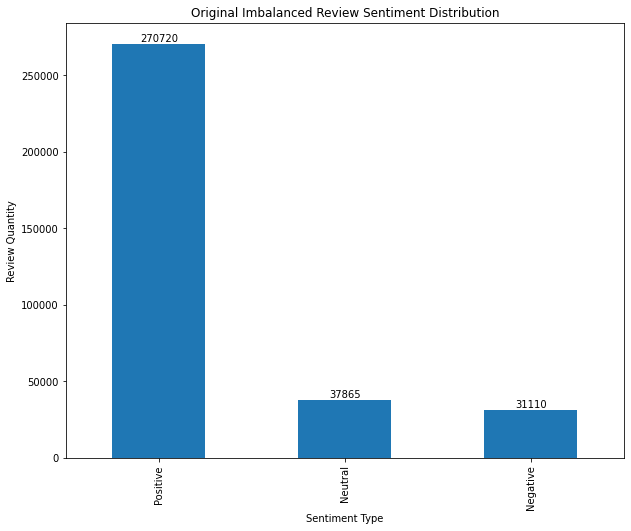

In [5]:
# original imbalanced 

df_class = df['Label'].value_counts().reset_index()
df_class['index'] = df_class['index'].apply(lambda x: {2: "Positive", 1:'Neutral', 0:"Negative"}.get(x))
df_class.set_index('index', inplace=True)
df_class.index.name = "Sentiment Type"
ax = df_class.plot(kind='bar', title='Original Imbalanced Review Sentiment Distribution',
                   figsize=(10, 8),
                   legend=False,
                    );
ax.bar_label(ax.containers[0])
ax.set_ylabel("Review Quantity");

In [6]:
# balance up the proportion
avg_list = [
    df[df['Label'] == 0].index.size,
    df[df['Label'] == 1].index.size,
]
min_review_count = min(avg_list)
print(f"Min review count: {min_review_count}")

# each type use sample number of samples
df_goodlabel = df[df['Label'] == 2].sample(
    min_review_count, random_state=10)
df_neutrallabel = df[df['Label'] == 1].sample(
    min_review_count, random_state=10)
df_badlabel = df[df['Label'] == 0].sample(
    min_review_count, random_state=10)

df_balanced = pd.concat([df_goodlabel, df_neutrallabel, df_badlabel], ignore_index=True)

Min review count: 31110


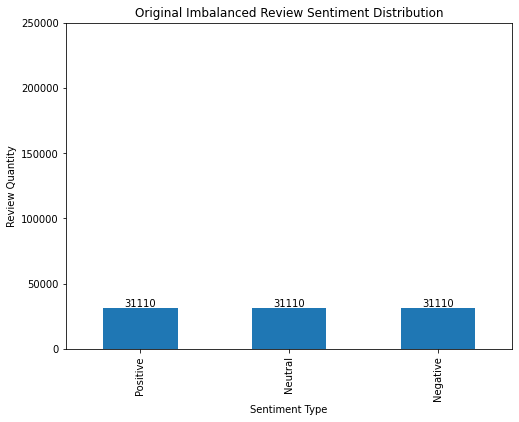

In [7]:
# Balanced dataset 

df_class2 = df_balanced['Label'].value_counts().reset_index()
df_class2['index'] = df_class2['index'].apply(lambda x: {2: "Positive", 1:'Neutral', 0:"Negative"}.get(x))
df_class2.set_index('index', inplace=True)
df_class2.index.name = "Sentiment Type"
ax2 = df_class2.plot(kind='bar', title='Original Imbalanced Review Sentiment Distribution',
                    figsize=(8, 6),
                    legend=False, 
                    );
ax2.set_ylim(top=250000)
ax2.bar_label(ax2.containers[0])
ax2.set_ylabel("Review Quantity");

# Machine Learning

In [8]:
# ========== Machine learing ============
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split


stopwordz = set(stopwords.words("English"))
stopwordz.remove('not') # remove negative

### train test split

In [9]:
X = df_balanced
y = df_balanced["Label"]

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10, stratify=y)

#### Example of top tokens

### Vectorization

In [10]:
# vectorization

vect = CountVectorizer(stop_words=stopwordz, ngram_range=(1, 2), max_features=3000)
vect.fit(df_balanced["Review"])

CountVectorizer(max_features=3000, ngram_range=(1, 2),
                stop_words={'a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...})

### Feature Engineering

In [11]:
# Convert the tokens into features
X_vec_train = vect.transform(X_train['Review'])
X_vec_test = vect.transform(X_test['Review'])

X_train = pd.DataFrame(X_vec_train.toarray(), columns=vect.get_feature_names_out())
X_test = pd.DataFrame(X_vec_test.toarray(), columns=vect.get_feature_names_out())

# convert the index back to original
X_train.index = y_train.index
X_test.index = y_test.index

Example of spare matrix used to fit into machine learning traning model

In [12]:
# features 
X_train

,00,10,10 mins,10 minutes,10 service,100,10pm,11,12,13,...,years,years ago,yellow,yes,yesterday,yet,young,yum,yummy,zero
80185,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84446,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
57385,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49091,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
87225,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51756,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
66544,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83831,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41753,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# labels
y_train

80185    0
84446    0
57385    1
49091    1
87225    0
        ..
51756    1
66544    0
83831    0
41753    1
65042    0
Name: Label, Length: 65331, dtype: int64

## Multiclass classification

### Prototype Models

#### Logistic Regression

In [225]:
from sklearn.linear_model import LogisticRegression

# ------- Logistic Regression -------
lg_classifier = LogisticRegression(max_iter=2000)
if test:
    sampleSize = 1000
    lg_classifier.fit(X_train.sample(sampleSize, random_state=10),
                      y_train.sample(sampleSize, random_state=10))
else:
    lg_classifier.fit(X_train, y_train)

# find the most informative words
log_odds = lg_classifier.coef_[0]
coeff = pd.DataFrame(log_odds, X_train.columns, columns=['coef'])\
    .sort_values(by='coef', ascending=False)

pred_lg_train = lg_classifier.predict(X_train)
pred_lg_test = lg_classifier.predict(X_test)

#### MultinomialNB

In [226]:
from sklearn.naive_bayes import MultinomialNB

nb_classifier = MultinomialNB()
if test:
    sampleSize = 1000
    nb_classifier.fit(X_train.sample(sampleSize, random_state=10),
                      y_train.sample(sampleSize, random_state=10))
else:
    nb_classifier.fit(X_train, y_train)
pred_nb_train = nb_classifier.predict(X_train)
pred_nb_test = nb_classifier.predict(X_test)

#### Support Vector Machine (SVM)

In [227]:
from sklearn import svm

# DO sampling for svm, due to computationally intensive
svm_classifier = svm.SVC(kernel='linear')
if test:
    sampleSize = 100
else:
    sampleSize = 2000
svm_classifier.fit(X_train.sample(sampleSize, random_state=10),
                   y_train.sample(sampleSize, random_state=10))
pred_svm_train = svm_classifier.predict(X_train)
pred_svm_test = svm_classifier.predict(X_test)

#### Random Forest

In [228]:
from sklearn.ensemble import RandomForestClassifier

forest_classifier = RandomForestClassifier(max_features=100)
if test:
    sampleSize = 200
else:
    sampleSize = X_train.index.size
forest_classifier.fit(X_train.sample(sampleSize, random_state=10),
                      y_train.sample(sampleSize, random_state=10))
pred_forest_train = forest_classifier.predict(X_train)
pred_forest_test = forest_classifier.predict(X_test)

In [71]:
pred_forest_train = forest_classifier.predict(X_train)
pred_forest_test = forest_classifier.predict(X_test)

In [51]:
# # load pre-trained models

# from joblib import load

# lg_classifier = load('models/lg_classifier_multiclass.joblib')
# nb_classifier = load('models/nb_classifier_multiclass.joblib')
# svm_classifier = load('models/svm_classifier_multiclass.joblib')
# forest_classifier = load('models/forest_classifier_multiclass.joblib')

#### Accuracy scores based on unoptimized ML models

In [41]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [73]:
# Logistic Regression
pred_lg_train = lg_classifier.predict(X_train)
print("Logistic_train")
print(f"Accuracy: {accuracy_score(y_train, pred_lg_train)}")
print(f"Precision: {precision_score(y_train, pred_lg_train, average='macro')}")
print(f"Recall: {recall_score(y_train, pred_lg_train, average='macro')}")
print(f"F1-score: {f1_score(y_train, pred_lg_train, average='macro')}")

Logistic_train
Accuracy: 0.7506390534355819
Precision: 0.7480980190650796
Recall: 0.7506390534355819
F1-score: 0.7488811607563318


In [78]:
# Multinomial Naive Bayes
pred_nb_train = nb_classifier.predict(X_train)
print("NaiveBayes_train")
print(f"Accuracy: {accuracy_score(y_train, pred_nb_train)}")
print(f"Precision: {precision_score(y_train, pred_nb_train, average='macro')}")
print(f"Recall: {recall_score(y_train, pred_nb_train, average='macro')}")
print(f"F1-score: {f1_score(y_train, pred_nb_train, average='macro')}")

NaiveBayes_train
Accuracy: 0.7015964855887711
Precision: 0.703480244881983
Recall: 0.701596485588771
F1-score: 0.7016922188419384


In [80]:
# SVM
pred_svm_train = svm_classifier.predict(X_train)
print("SVM_train")
print(f"Accuracy: {accuracy_score(y_train, pred_svm_train)}")
print(f"Precision: {precision_score(y_train, pred_svm_train, average='macro')}")
print(f"Recall: {recall_score(y_train, pred_svm_train, average='macro')}")
print(f"F1-score: {f1_score(y_train, pred_svm_train, average='macro')}")

SVM_train
Accuracy: 0.6123892179822749
Precision: 0.6094951230619391
Recall: 0.6123892179822749
F1-score: 0.6102941077355012


In [79]:
# Random Forest
pred_forest_train = forest_classifier.predict(X_train)
print("RandomForest_train")
print(f"Accuracy: {accuracy_score(y_train, pred_forest_train)}")
print(f"Precision: {precision_score(y_train, pred_forest_train, average='macro')}")
print(f"Recall: {recall_score(y_train, pred_forest_train, average='macro')}")
print(f"F1-score: {f1_score(y_train, pred_forest_train, average='macro')}")

RandomForest_train
Accuracy: 0.9860709311046824
Precision: 0.9860766932648026
Recall: 0.9860709311046824
F1-score: 0.9860670996259163


### Fine-tune Hyperparameters

In [71]:
# # load pre-trained models

# from joblib import load

# lg_classifier_best = load('models/lg_classifier_best_multiclass.joblib')
# nb_classifier_best = load('models/nb_classifier_best_multiclass.joblib')
# svm_classifier_best = load('models/svm_classifier_best_multiclass.joblib')
# forest_classifier_best = load('models/forest_classifier_best_multiclass.joblib')

In [32]:
# for stratified cross validation
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

In [30]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

#### Logistic Regression

In [232]:
# logistic regressiion
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 0.1, 0.01]

# define grid search
grid = dict(solver=solvers, penalty=penalty, C=c_values)
grid_search = GridSearchCV(estimator=lg_classifier, 
                           param_grid=grid,
                           n_jobs=-1,
                           cv=kf,
                           scoring='accuracy',
                           error_score=0)

if test:
    sampleSize = 500
    logistic_grid = grid_search.fit(X_train.sample(sampleSize, random_state=10),
                      y_train.sample(sampleSize, random_state=10))
else:
    logistic_grid = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (logistic_grid.best_score_, logistic_grid.best_params_))
means = logistic_grid.cv_results_['mean_test_score']
stds = logistic_grid.cv_results_['std_test_score']
params = logistic_grid.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))
lg_classifier_best = logistic_grid.best_estimator_

Best: 0.707490 using {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


#### Multinomial Naive Bayes

In [236]:
alpha = [1, 1e-10]
fit_prior = [True, False]

# define grid search
grid = dict(alpha=alpha, fit_prior=fit_prior)
grid_search = GridSearchCV(estimator=nb_classifier, 
                           param_grid=grid,
                           n_jobs=-1,
                           cv=kf,
                           scoring='accuracy',
                           error_score=0)

if test:
    sampleSize = 500
    nb_grid = grid_search.fit(X_train.sample(sampleSize, random_state=10),
                      y_train.sample(sampleSize, random_state=10))
else:
    nb_grid = grid_search.fit(X_train, y_train)


# summarize results
print("Best: %f using %s" % (nb_grid.best_score_, nb_grid.best_params_))
means = nb_grid.cv_results_['mean_test_score']
stds = nb_grid.cv_results_['std_test_score']
params = nb_grid.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))
nb_classifier_best = nb_grid.best_estimator_

Best: 0.690591 using {'alpha': 1e-10, 'fit_prior': False}


#### SVM

In [102]:
param_grid = {'C':[0.1, 1],'gamma':[0.0001, 'scale'],'kernel':['rbf']}
svc = svm.SVC(probability=True)
grid_search = GridSearchCV(svc, param_grid, scoring='accuracy', cv=kf)
# sampling as computationally intensive
if test:
    samplingSize = 100
else:
    samplingSize = 2000
svm_grid = grid_search.fit(X_train.sample(samplingSize, random_state=10), y_train.sample(samplingSize, random_state=10))

print("Best: %f using %s" % (svm_grid.best_score_, svm_grid.best_params_))
means = svm_grid.cv_results_['mean_test_score']
stds = svm_grid.cv_results_['std_test_score']
params = svm_grid.cv_results_['params']

svm_classifier_best = svm_grid.best_estimator_

Best: 0.624500 using {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}


#### Random Forest

In [103]:
import numpy as np
from pprint import pprint

# Random Forest
# Number of trees in random forest
n_estimators = [2, 10, 100]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [2, 10]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
from sklearn.model_selection import RandomizedSearchCV

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=forest_classifier,
                               param_distributions=random_grid,
                               n_iter=100,
                               cv=kf,
                               verbose=0,
                               random_state=10,
                               n_jobs = -1,
                               scoring='accuracy')
# Fit the random search model
if test:
    samplingSize = 100 # for test
else:
    samplingSize = X_train.index.size

rf_search = rf_random.fit(X_train.sample(samplingSize, random_state=10), y_train.sample(samplingSize, random_state=10))

# best model of the random forest model
print("Best: %f using %s" % (rf_search.best_score_, rf_search.best_params_))
means = rf_search.cv_results_['mean_test_score']
stds = rf_search.cv_results_['std_test_score']
params = rf_search.cv_results_['params']
forest_classifier_best = rf_search.best_estimator_

/Users/ckng/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=100. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best: 0.686382 using {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': None, 'bootstrap': False}


### Results of fine-tuned models

##### Accuracy, Precision, Recall, F1-score

In [239]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [240]:
# Logistic Regression
pred_lg_test = lg_classifier_best.predict(X_test)
print("Logistic_test")
print(f"Accuracy: {accuracy_score(y_test, pred_lg_test)}")
print(f"Precision: {precision_score(y_test, pred_lg_test, average='macro')}")
print(f"Recall: {recall_score(y_test, pred_lg_test, average='macro')}")
print(f"F1-score: {f1_score(y_test, pred_lg_test, average='macro')}")

Logistic_test
Accuracy: 0.7114182649380335
Precision: 0.7064240665925423
Recall: 0.7114182649380335
F1-score: 0.7072982353142248


In [241]:
# Naive Bayes
pred_nb_test = nb_classifier_best.predict(X_test)
print("Naive Bayes_test")
print(f"Accuracy: {accuracy_score(y_test, pred_nb_test)}")
print(f"Precision: {precision_score(y_test, pred_nb_test, average='macro')}")
print(f"Recall: {recall_score(y_test, pred_nb_test, average='macro')}")
print(f"F1-score: {f1_score(y_test, pred_nb_test, average='macro')}")

Naive Bayes_test
Accuracy: 0.6917032751169685
Precision: 0.6929546596930974
Recall: 0.6917032751169684
F1-score: 0.6914737730096429


In [242]:
# SVM
pred_svm_test = svm_classifier_best.predict(X_test)
print("SVM_test")
print(f"Accuracy: {accuracy_score(y_test, pred_svm_test)}")
print(f"Precision: {precision_score(y_test, pred_svm_test, average='macro')}")
print(f"Recall: {recall_score(y_test, pred_svm_test, average='macro')}")
print(f"F1-score: {f1_score(y_test, pred_svm_test, average='macro')}")

SVM_test
Accuracy: 0.6310939676417014
Precision: 0.6260198181031699
Recall: 0.6310939676417014
F1-score: 0.6206289382085725


In [243]:
# Random Forest
pred_forest_test = forest_classifier_best.predict(X_test)
print("Random Forest_test")
print(f"Accuracy: {accuracy_score(y_test, pred_forest_test)}")
print(f"Precision: {precision_score(y_test, pred_forest_test, average='macro')}")
print(f"Recall: {recall_score(y_test, pred_forest_test, average='macro')}")
print(f"F1-score: {f1_score(y_test, pred_forest_test, average='macro')}")

Random Forest_test
Accuracy: 0.6885603057252044
Precision: 0.6838288247169375
Recall: 0.6885603057252045
F1-score: 0.6850833925997631


### Confusion Matrix


In [245]:
from sklearn.metrics import confusion_matrix
import seaborn as sns;

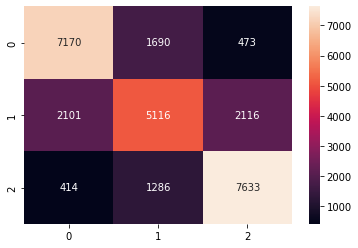

In [246]:
# Logistic Regression

cf_matrix = confusion_matrix(y_test, pred_lg_test)
sns.heatmap(cf_matrix, annot=True, fmt='.4g');

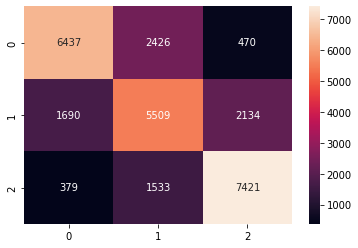

In [247]:
# Naive Bayes

cf_matrix = confusion_matrix(y_test, pred_nb_test)
sns.heatmap(cf_matrix, annot=True, fmt='.4g');

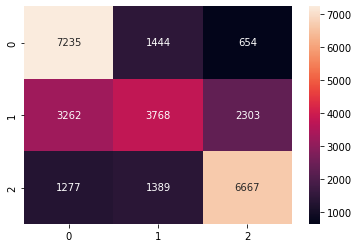

In [248]:
# SVM

cf_matrix = confusion_matrix(y_test, pred_svm_test)
sns.heatmap(cf_matrix, annot=True, fmt='.4g');

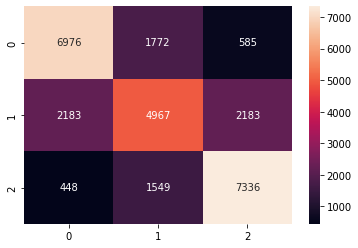

In [249]:
# Random Forest

cf_matrix = confusion_matrix(y_test, pred_forest_test)
sns.heatmap(cf_matrix, annot=True, fmt='.4g');

### Export Modals

#### Exports all the prototype models

In [282]:
# export all prototype models
import pickle
from joblib import dump

exportPrototypeModels = exportModel

if exportPrototypeModels:
    # logistic regression
    dump(lg_classifier, 'models/lg_classifier_multiclass.joblib') 

    # naive bayes
    dump(nb_classifier, 'models/nb_classifier_multiclass.joblib') 

    # SVM
    dump(svm_classifier, 'models/svm_classifier_multiclass.joblib') 

    # Random Forest
    dump(forest_classifier, 'models/forest_classifier_multiclass.joblib') 

#### Exports all the fined-tuned models

In [244]:
# export best estimators
import pickle
from joblib import dump

exportFineTunedModels = exportModel

# {True, False}

if exportFineTunedModels:
    # logistic regression
    dump(lg_classifier_best, 'models/lg_classifier_best_multiclass.joblib') 

    # naive bayes
    dump(nb_classifier_best, 'models/nb_classifier_best_multiclass.joblib') 

    # SVM
    dump(svm_classifier_best, 'models/svm_classifier_best_multiclass.joblib') 

    # Random Forest
    dump(forest_classifier_best, 'models/forest_classifier_best_multiclass.joblib') 

#### Export best model to web app

In [250]:
import joblib

# export model to webapp
# exportWebApp = False # {True, False}
exportWebApp = exportModel # {True, False}

if exportWebApp:
    classifierPath = os.path.join(master_dir, 'WebApp', 'sentiment', 'classifier')
    os.makedirs(classifierPath, exist_ok=True)
    # nb classifier
    joblib.dump(nb_classifier_best, os.path.join(classifierPath, 'nb_classifier_multiclass.pkl'))
    # logistic classifier
    joblib.dump(lg_classifier_best, os.path.join(classifierPath, 'lg_classifier_multiclass.pkl'))

    joblib.dump(vect, os.path.join(classifierPath, 'vectorizer_multiclass.pkl'))

## Binary Classification

In [55]:
df_binary = pd.concat([df_goodlabel, df_badlabel], ignore_index=True)

df_binary["Label"] = df_binary["Label"].astype(str).str.replace("2", "1")

In [56]:
X = df_binary
y = df_binary["Label"]

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=10, stratify=y)

In [57]:
# vectorization

vect_bin = CountVectorizer(stop_words=stopwordz, ngram_range=(1, 2), max_features=5000)
vect_bin.fit(df_binary["Review"])

CountVectorizer(max_features=5000, ngram_range=(1, 2),
                stop_words={'a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...})

In [58]:
# Feature engineering
X_vec_train = vect_bin.transform(X_train['Review'])
X_vec_test = vect_bin.transform(X_test['Review'])


X_train = pd.DataFrame(X_vec_train.toarray(), columns=vect_bin.get_feature_names_out())
X_test = pd.DataFrame(X_vec_test.toarray(), columns=vect_bin.get_feature_names_out())

#### Protoype models

In [255]:
from sklearn.linear_model import LogisticRegression

# ------- Logistic Regression -------
lg_classifier_bin = LogisticRegression(max_iter=2000)


if test:
    sampleSize = 500
    lg_classifier_bin.fit(X_train.sample(sampleSize, random_state=10),
                      y_train.sample(sampleSize, random_state=10))
else:
    lg_classifier_bin.fit(X_train, y_train)

# find the most informative words
log_odds = lg_classifier_bin.coef_[0]
coeff = pd.DataFrame(log_odds, X_train.columns, columns=['coef'])\
    .sort_values(by='coef', ascending=False)

In [256]:
pred_lg_train = lg_classifier_bin.predict(X_train)

In [257]:
from sklearn.naive_bayes import MultinomialNB

nb_classifier_bin = MultinomialNB()
if test:
    sampleSize = 500
    nb_classifier_bin.fit(X_train.sample(sampleSize, random_state=10),
                      y_train.sample(sampleSize, random_state=10))
else:
    nb_classifier_bin.fit(X_train, y_train)
pred_nb_train = nb_classifier_bin.predict(X_train)

In [258]:
from sklearn import svm

svm_classifier_bin = svm.SVC()
if test:
    sampleSize = 100
else:
    sampleSize = 2000
svm_classifier_bin.fit(X_train.sample(sampleSize, random_state=10), y_train.sample(sampleSize, random_state=10))
pred_svm_train = svm_classifier_bin.predict(X_train)

In [259]:
from sklearn.ensemble import RandomForestClassifier

forest_classifier_bin = RandomForestClassifier(max_features=100)
if test:
    sampleSize = 100
else:
    sampleSize = X_train.index.size
    
forest_classifier_bin.fit(X_train.sample(sampleSize, random_state=10), y_train.sample(sampleSize, random_state=10))
pred_forest_train = forest_classifier_bin.predict(X_train)

In [260]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

print(f"Logistic_train_accuracy: {accuracy_score(y_train, pred_lg_train)}")
print(f"Logistic_train_precision: {precision_score(y_train, pred_lg_train, pos_label='1')}")
print(f"Logistic_train_recall: {recall_score(y_train, pred_lg_train, pos_label='1')}")
print(f"Logistic_train_f1: {f1_score(y_train, pred_lg_train, pos_label='1')}")
print("=============")

print(f"NaiveBayes_train_accuracy: {accuracy_score(y_train, pred_nb_train)}")
print(f"NaiveBayes_train_precision: {precision_score(y_train, pred_nb_train, pos_label='1')}")
print(f"NaiveBayes_train_recall: {recall_score(y_train, pred_nb_train, pos_label='1')}")
print(f"NaiveBayes_train_f1: {f1_score(y_train, pred_nb_train, pos_label='1')}")
print("=============")

print(f"SVM_train_accuracy: {accuracy_score(y_train, pred_svm_train)}")
print(f"SVM_train_precision: {precision_score(y_train, pred_svm_train, pos_label='1')}")
print(f"SVM_train_recall: {recall_score(y_train, pred_svm_train, pos_label='1')}")
print(f"SVM_train_f1: {f1_score(y_train, pred_svm_train, pos_label='1')}")
print("=============")


print(f"RandomForest_train_accuracy: {accuracy_score(y_train, pred_forest_train)}")
print(f"RandomForest_train_precision: {precision_score(y_train, pred_forest_train, pos_label='1')}")
print(f"RandomForest_train_recall: {recall_score(y_train, pred_forest_train, pos_label='1')}")
print(f"RandomForest_train_f1: {f1_score(y_train, pred_forest_train, pos_label='1')}")
print("=============")

Logistic_train_accuracy: 0.9502915920466547
Logistic_train_precision: 0.9488282680336872
Logistic_train_recall: 0.9519217523074803
Logistic_train_f1: 0.9503724928366761
NaiveBayes_train_accuracy: 0.9135785461725674
NaiveBayes_train_precision: 0.9065956390230689
NaiveBayes_train_recall: 0.922165587546494
NaiveBayes_train_f1: 0.9143143325441632
SVM_train_accuracy: 0.8590714974514396
SVM_train_precision: 0.8832148983092379
SVM_train_recall: 0.8275703724112596
SVM_train_f1: 0.8544876961737234
RandomForest_train_accuracy: 0.9951324792211966
RandomForest_train_precision: 0.9966834031968308
RandomForest_train_recall: 0.9935711989713918
RandomForest_train_f1: 0.9951248677735363


### Fine-tuning hyperparameters

In [16]:
# # load pre-trained models

from joblib import load

# lg_classifier_best_bin = load('models/lg_classifier_best_binary.joblib')
# nb_classifier_best_bin = load('models/nb_classifier_best_binary.joblib')
# svm_classifier_best_bin = load('models/svm_classifier_best_binary.joblib')
# forest_classifier_best_bin = load('models/forest_classifier_best_binary.joblib')

In [27]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

In [28]:
# for stratified cross validation
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

#### Logistic Regression

In [263]:
# logistic regressiion
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 1.0, 0.01]

# define grid search
grid = dict(solver=solvers, penalty=penalty, C=c_values)
grid_search = GridSearchCV(estimator=lg_classifier_bin, 
                           param_grid=grid,
                           n_jobs=-1,
                           cv=kf,
                           scoring='accuracy',
                           error_score=0)
if test:
    sampleSize = 100
    logistic_grid = grid_search.fit(X_train.sample(samplingSize, random_state=10),
             y_train.sample(samplingSize, random_state=10))
else:
    logistic_grid = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (logistic_grid.best_score_, logistic_grid.best_params_))
means = logistic_grid.cv_results_['mean_test_score']
stds = logistic_grid.cv_results_['std_test_score']
params = logistic_grid.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))
lg_classifier_best_bin = logistic_grid.best_estimator_

Best: 0.914635 using {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}


#### Multinomial Naive Bayes

In [264]:
# Naive Bayes
alpha = [1, 1e-10]
fit_prior = [True, False]

# define grid search
grid = dict(alpha=alpha, fit_prior=fit_prior)
grid_search = GridSearchCV(estimator=nb_classifier_bin, 
                           param_grid=grid,
                           n_jobs=-1,
                           cv=kf,
                           scoring='accuracy',
                           error_score=0)
if test:
    sampleSize = 100
    nb_grid = grid_search.fit(X_train.sample(samplingSize, random_state=10),
             y_train.sample(samplingSize, random_state=10))
else:
    nb_grid = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (nb_grid.best_score_, nb_grid.best_params_))
means = nb_grid.cv_results_['mean_test_score']
stds = nb_grid.cv_results_['std_test_score']
params = nb_grid.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))
nb_classifier_best_bin = nb_grid.best_estimator_

Best: 0.909629 using {'alpha': 1, 'fit_prior': False}


#### SVM

In [60]:
param_grid = {'C':[0.1,1, 10, 100],'gamma':[0.0001,0.001,'scale'],'kernel':['rbf']
svc = svm.SVC(probability=True)
svm_grid = GridSearchCV(svc, param_grid, scoring='accuracy', cv=kf)
# sampling as computationally intensive
if test:
    samplingSize = 100 # for test
else:
    samplingSize = 5000
svm_grid.fit(X_train.sample(samplingSize, random_state=10),
             y_train.sample(samplingSize, random_state=10))

# summarize results
print("Best: %f using %s" % (svm_grid.best_score_, svm_grid.best_params_))
means = svm_grid.cv_results_['mean_test_score']
stds = svm_grid.cv_results_['std_test_score']
params = svm_grid.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))
svm_classifier_best_bin = svm_grid.best_estimator_

Best: 0.881000 using {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}


In [63]:
import numpy as np
from pprint import pprint

# Random Forest
# Number of trees in random forest
n_estimators = [2, 100]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [2, 10]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
from sklearn.model_selection import RandomizedSearchCV

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=forest_classifier_bin,
                               param_distributions=random_grid,
                               n_iter=100,
                               cv=kf,
                               verbose=0,
                               random_state=10,
                               n_jobs = -1,
                               scoring='accuracy')
# Fit the random search model
if test:
    samplingSize = 100 # for test
else:
    samplingSize = X_train.index.size
rf_search = rf_random.fit(X_train.sample(samplingSize, random_state=10),
                          y_train.sample(samplingSize, random_state=10))

# summarize results
print("Best: %f using %s" % (rf_search.best_score_, rf_search.best_params_))
means = rf_search.cv_results_['mean_test_score']
stds = rf_search.cv_results_['std_test_score']
params = rf_search.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))
forest_classifier_best_bin = rf_search.best_estimator_

/Users/ckng/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best: 0.894223 using {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}


### ROC Curve

In [32]:
# !!! used after cross-validation later

In [33]:
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_predict


# Logistic Regression
y_probas_logistic = cross_val_predict(lg_classifier_best_bin, X_train, y_train, cv=kf, method="predict_proba")
y_scores_logistic = y_probas_logistic[:, 1] # score = proba of positive class
fpr_logistic, tpr_logistic, thresholds_logistic = roc_curve(y_train, y_scores_logistic, pos_label='1')

# Naive Bayes
y_probas_nb = cross_val_predict(nb_classifier_best_bin, X_train, y_train, cv=kf, method="predict_proba")
y_scores_nb = y_probas_nb[:, 1] # score = proba of positive class
fpr_nb, tpr_nb, thresholds_logistic = roc_curve(y_train, y_scores_logistic, pos_label='1')

# SVM
if test:
    sampleSize = 100
else:
    sampleSize = 2000
y_probas_svm = cross_val_predict(svm_classifier_best_bin,
                                 X_train.sample(sampleSize, random_state=10),
                                 y_train.sample(sampleSize, random_state=10),
                                 cv=kf, method="predict_proba")
y_scores_svm = y_probas_svm[:, 1] # score = proba of positive class
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_train.sample(sampleSize, random_state=10),
                                             y_scores_svm, pos_label='1')

# Random Forest
if test:
    sampleSize = 100
else:
    sampleSize = X_train.index.size
y_probas_forest = cross_val_predict(forest_classifier_best_bin,
                                    X_train.sample(sampleSize, random_state=10),
                                     y_train.sample(sampleSize, random_state=10),
                                    cv=kf, method="predict_proba")
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train.sample(sampleSize, random_state=10),
                                                      y_scores_forest, pos_label='1')

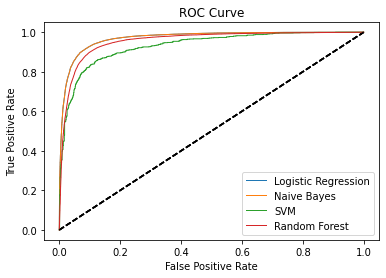

In [34]:
def plot_roc_curve(fpr, tpr, label=None): 
    plt.plot(fpr, tpr, linewidth=1, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr_logistic, tpr_logistic, "Logistic Regression") # Logistic Regression
plot_roc_curve(fpr_nb, tpr_nb, "Naive Bayes") # Naive Bayes
plot_roc_curve(fpr_svm, tpr_svm, "SVM") # Naive Bayes
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest") # Random Forest
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

### Test

In [35]:
# Logistic Regression
pred_lg_test = lg_classifier_best_bin.predict(X_test)
print(f"Logistic_test: {accuracy_score(y_test, pred_lg_test)}")
print(f"Logistic_test_precision: {precision_score(y_test, pred_lg_test, pos_label='1')}")
print(f"Logistic_test_recall: {recall_score(y_test, pred_lg_test, pos_label='1')}")
print(f"Logistic_test_f1: {f1_score(y_test, pred_lg_test, pos_label='1')}")

Logistic_test: 0.9170148933890496
Logistic_test_precision: 0.9120262544992589
Logistic_test_recall: 0.9230686810243223
Logistic_test_f1: 0.9175142446349647


In [36]:
# Naive Bayes
pred_nb_test = nb_classifier_best_bin.predict(X_test)
print(f"NaiveBayes_test: {accuracy_score(y_test, pred_nb_test)}")
print(f"NaiveBayes_test_precision: {precision_score(y_test, pred_nb_test, pos_label='1')}")
print(f"NaiveBayes_test_recall: {recall_score(y_test, pred_nb_test, pos_label='1')}")
print(f"NaiveBayes_test_f1: {f1_score(y_test, pred_nb_test, pos_label='1')}")

NaiveBayes_test: 0.9107468123861566
NaiveBayes_test_precision: 0.9015397507070284
NaiveBayes_test_recall: 0.9222115075538412
NaiveBayes_test_f1: 0.9117584745762711


In [62]:
# SVM
pred_svm_test = svm_classifier_best_bin.predict(X_test)
print(f"SVM_test: {accuracy_score(y_test, pred_svm_test)}")
print(f"SVM_test_precision: {precision_score(y_test, pred_svm_test, pos_label='1')}")
print(f"SVM_test_recall: {recall_score(y_test, pred_svm_test, pos_label='1')}")
print(f"SVM_test_f1: {f1_score(y_test, pred_svm_test, pos_label='1')}")

SVM_test: 0.8895317689917497
SVM_test_precision: 0.88232201072668
SVM_test_recall: 0.8989606771670416
SVM_test_f1: 0.8905636344337119


In [64]:
# Random Forest
pred_forest_test = forest_classifier_best_bin.predict(X_test)
print(f"RandomForest_test: {accuracy_score(y_test, pred_forest_test)}")
print(f"RandomForest_test_precision: {precision_score(y_test, pred_forest_test, pos_label='1')}")
print(f"RandomForest_test_recall: {recall_score(y_test, pred_forest_test, pos_label='1')}")
print(f"RandomForest_test_f1: {f1_score(y_test, pred_forest_test, pos_label='1')}")

RandomForest_test: 0.8981570770384657
RandomForest_test_precision: 0.9088908450704225
RandomForest_test_recall: 0.885031608271724
RandomForest_test_f1: 0.8968025622930351


### Confusion Matrix

In [53]:
from sklearn.metrics import confusion_matrix
import seaborn as sns;

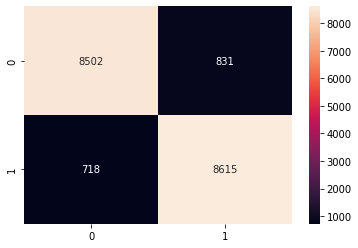

In [40]:
# Logistic Regression

cf_matrix = confusion_matrix(y_test, pred_lg_test)
sns.heatmap(cf_matrix, annot=True, fmt='.4g');

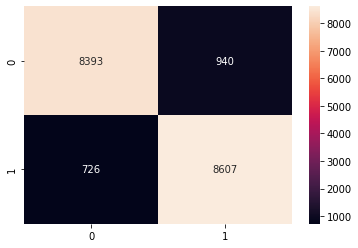

In [41]:
# Naive Bayes

cf_matrix = confusion_matrix(y_test, pred_nb_test)
sns.heatmap(cf_matrix, annot=True, fmt='.4g');

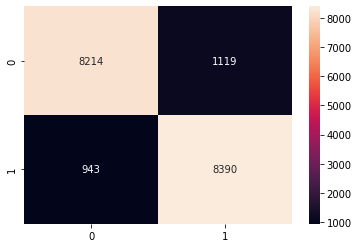

In [65]:
# SVM

cf_matrix = confusion_matrix(y_test, pred_svm_test)
sns.heatmap(cf_matrix, annot=True, fmt='.4g');

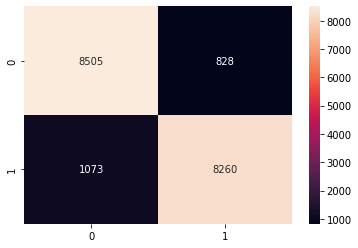

In [66]:
# Random Forest

cf_matrix = confusion_matrix(y_test, pred_forest_test)
sns.heatmap(cf_matrix, annot=True, fmt='.4g');

### Export Binary Classifier

#### Export to Web App

In [44]:
import joblib

# export model to webapp
exportWebApp = exportModel # {True, False}

if exportWebApp:
    classifierPath = os.path.join(master_dir, 'WebApp', 'sentiment', 'classifier')
    os.makedirs(classifierPath, exist_ok=True)
    # nb classifier
    joblib.dump(nb_classifier_best_bin, os.path.join(classifierPath, 'nb_classifier_binary.pkl'))
    # logistic classifier
    joblib.dump(lg_classifier_best_bin, os.path.join(classifierPath, 'lg_classifier_binary.pkl'))

    joblib.dump(vect_bin, os.path.join(classifierPath, 'vectorizer_binary.pkl'))

#### General Export

In [50]:
# export all prototype models
import pickle
from joblib import dump, load

exportPrototypeModels = exportModel

if exportPrototypeModels:
    logistic regression
    dump(lg_classifier_bin, 'models/lg_classifier_binary.joblib') 

    # naive bayes
    dump(nb_classifier_bin, 'models/nb_classifier_binary.joblib') 

    # SVM
    dump(svm_classifier_bin, 'models/svm_classifier_binary.joblib') 

    Random Forest
    dump(forest_classifier_bin, 'models/forest_classifier_binary.joblib') 

In [68]:
# export all fine tune best models
import pickle
from joblib import dump, load
exportFineTunedModels = exportModel

# {True, False}

if exportFineTunedModels:
    # logistic regression
    dump(lg_classifier_best_bin, 'models/lg_classifier_best_binary.joblib') 

    # naive bayes
    dump(nb_classifier_best_bin, 'models/nb_classifier_best_binary.joblib') 

    # SVM
    dump(svm_classifier_best_bin, 'models/svm_classifier_best_binary.joblib') 

    # Random Forest
    dump(forest_classifier_best_bin, 'models/forest_classifier_best_binary.joblib') 